In [17]:
import uproot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest

In [18]:
with uproot.open("ch3t_sr1.root") as f:
    arr = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')

In [19]:
arr = arr[(arr['S2_corrected_area'] > 0) & (arr['has_good_S1'] == True)]

arr.head()

,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,S2_width_ns,S2_peakAmp,...,S2_rmsWidth_ns,S2_fwhm_ns,S2_x_cm,S2_y_cm,S2_xy_chiSq,S2_n_saturated,has_good_S1,drift_time,S1_area,S1_corrected_area
1,8135,82510,186696.234375,56513.230469,130182.921875,0.394597,238570.812500,6.588514,13210.0,57.565643,...,1074.0,3050.0,-50.071304,-12.595337,5.003135,0.0,True,0.0,57323.050781,47940.609375
2,8135,82520,78.904518,26.663769,52.191383,0.323728,94.203354,0.002537,1510.0,0.146897,...,321.0,840.0,8.814517,26.112101,1.780685,0.0,True,0.0,3098.078613,2671.013184
3,8135,82525,432699.750000,136250.546875,296449.406250,0.370231,494962.906250,14.452450,12660.0,111.949219,...,1193.0,3900.0,-32.554398,2.414943,9.031620,0.0,True,0.0,2335.334473,2288.260010
5,8135,82537,505076.000000,164505.703125,340570.156250,0.348590,555800.000000,17.586535,3490.0,375.725708,...,387.0,1360.0,16.394835,-30.837593,6.550779,0.0,True,0.0,1220.329102,1304.582275
6,8135,82549,680541.312500,213399.015625,467142.062500,0.372855,741306.437500,22.620752,3300.0,493.790680,...,373.0,1390.0,40.913544,21.131460,54.538105,0.0,True,0.0,633.057129,675.012024


<AxesSubplot:>

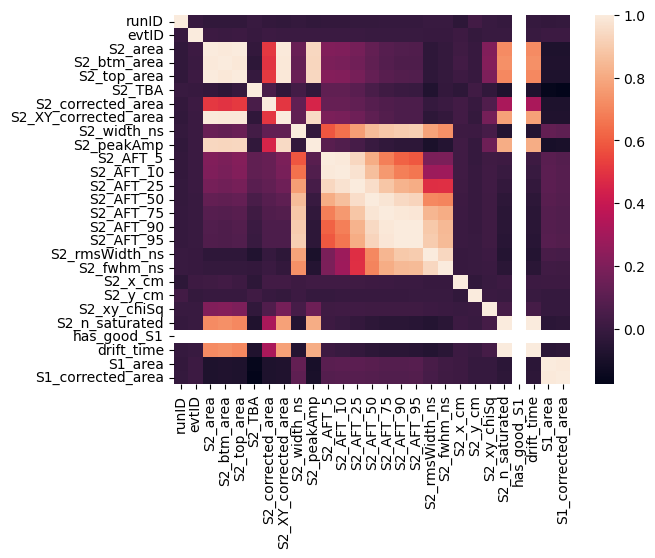

In [20]:
#plot everything against everything - corner plots n that 
corr_df = arr.corr()

corr_df.dropna()

sns.heatmap(corr_df,
           xticklabels = corr_df.columns,
           yticklabels=corr_df.columns,
           )



In [21]:
corr_df_cut=corr_df
for idx1 in corr_df.index:
    for idx2 in corr_df.index:
        if corr_df[idx1][idx2]>0.05:
            a=False
        else:
            a=True
        
    if a: 
        corr_df_cut=corr_df_cut.drop(index=idx1)
        corr_df_cut=corr_df_cut.drop(columns=idx1)
        
corr_df_cut

,S2_width_ns,S2_AFT_5,S2_AFT_10,S2_AFT_25,S2_AFT_50,S2_AFT_75,S2_AFT_90,S2_AFT_95,S1_area,S1_corrected_area
S2_width_ns,1.000000,0.582916,0.650244,0.768700,0.856075,0.888876,0.902780,0.908621,0.122410,0.111192
S2_AFT_5,0.582916,1.000000,0.993049,0.937969,0.809329,0.685977,0.612849,0.589206,0.095112,0.084518
S2_AFT_10,0.650244,0.993049,1.000000,0.970213,0.865482,0.754575,0.685902,0.663318,0.099926,0.088241
S2_AFT_25,0.768700,0.937969,0.970213,1.000000,0.957200,0.881918,0.826966,0.807101,0.100906,0.088620
S2_AFT_50,0.856075,0.809329,0.865482,0.957200,1.000000,0.977163,0.944323,0.929283,0.091931,0.080728
S2_AFT_75,0.888876,0.685977,0.754575,0.881918,0.977163,1.000000,0.990293,0.981686,0.082498,0.072557
S2_AFT_90,0.902780,0.612849,0.685902,0.826966,0.944323,0.990293,1.000000,0.998270,0.082527,0.073371
S2_AFT_95,0.908621,0.589206,0.663318,0.807101,0.929283,0.981686,0.998270,1.000000,0.086663,0.077688
S1_area,0.122410,0.095112,0.099926,0.100906,0.091931,0.082498,0.082527,0.086663,1.000000,0.994548
S1_corrected_area,0.111192,0.084518,0.088241,0.088620,0.080728,0.072557,0.073371,0.077688,0.994548,1.000000


,S2_width_ns,S2_AFT_5,S2_AFT_10,S2_AFT_25,S2_AFT_50,S2_AFT_75,S2_AFT_90,S2_AFT_95,S1_area,S1_corrected_area
S2_width_ns,1.000000,0.582916,0.650244,0.768700,0.856075,0.888876,0.902780,0.908621,0.122410,0.111192
S2_AFT_5,0.582916,1.000000,0.993049,0.937969,0.809329,0.685977,0.612849,0.589206,0.095112,0.084518
S2_AFT_10,0.650244,0.993049,1.000000,0.970213,0.865482,0.754575,0.685902,0.663318,0.099926,0.088241
S2_AFT_25,0.768700,0.937969,0.970213,1.000000,0.957200,0.881918,0.826966,0.807101,0.100906,0.088620
S2_AFT_50,0.856075,0.809329,0.865482,0.957200,1.000000,0.977163,0.944323,0.929283,0.091931,0.080728
S2_AFT_75,0.888876,0.685977,0.754575,0.881918,0.977163,1.000000,0.990293,0.981686,0.082498,0.072557
S2_AFT_90,0.902780,0.612849,0.685902,0.826966,0.944323,0.990293,1.000000,0.998270,0.082527,0.073371
S2_AFT_95,0.908621,0.589206,0.663318,0.807101,0.929283,0.981686,0.998270,1.000000,0.086663,0.077688
S1_area,0.122410,0.095112,0.099926,0.100906,0.091931,0.082498,0.082527,0.086663,1.000000,0.994548
S1_corrected_area,0.111192,0.084518,0.088241,0.088620,0.080728,0.072557,0.073371,0.077688,0.994548,1.000000


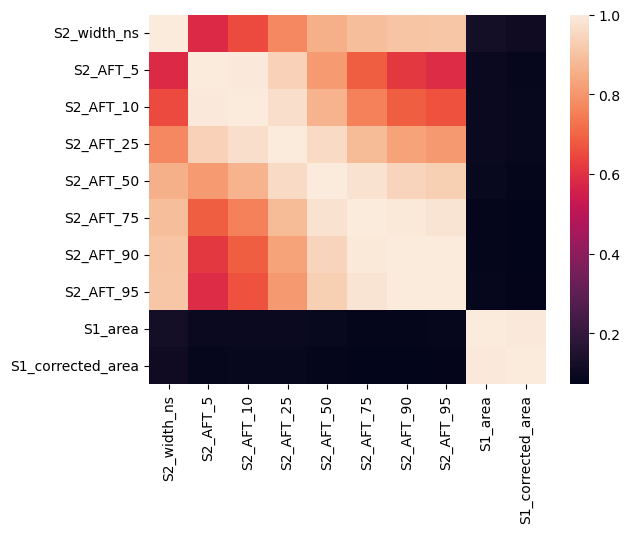

In [22]:
sns.heatmap(corr_df_cut,
           xticklabels = corr_df_cut.columns,
           yticklabels=corr_df_cut.columns,
           )
corr_df_cut

In [23]:
 def train_model(X_train,y_train,X_test,y_test):
    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42, max_delta_step = 1)

    model.fit(X_train,
            y_train,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('BDT_model')

    return model

In [24]:
features = ['S2_width_ns', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25', 'S2_AFT_50', 'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95']
#for col in corr_df_cut.columns:
#    features.append(col)
    
#print(features)


/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [178388, 713551]

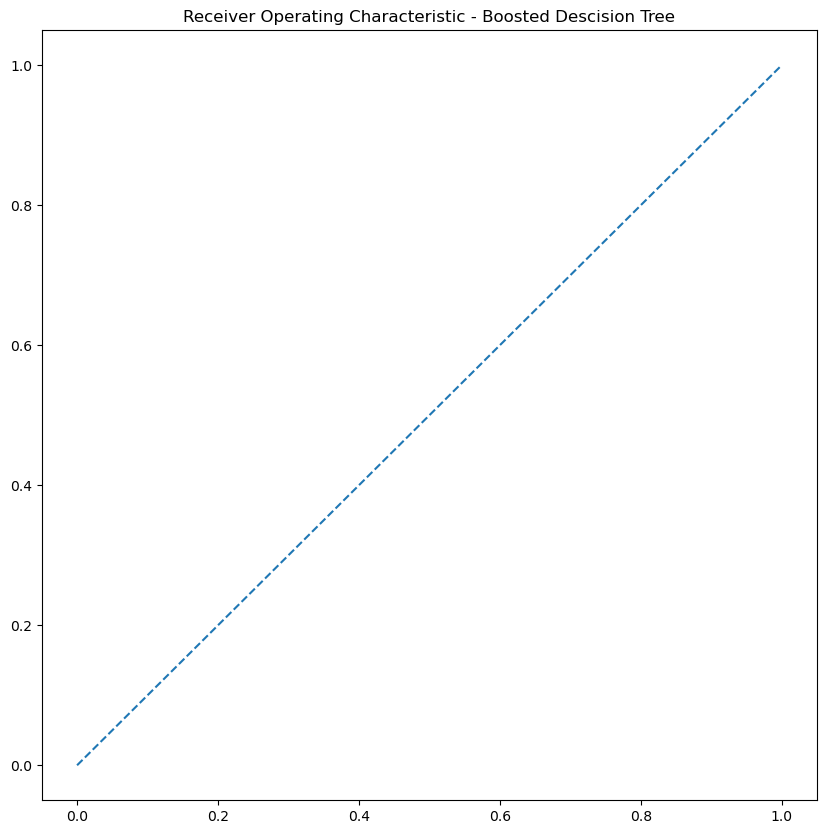

In [25]:
seed = 42
test_size = 0.2
y = arr.loc[:, ['S2_width_ns']]
X = arr.loc[:, features]
#Creating the three different data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
reg = DecisionTreeRegressor(max_depth = 2, random_state = seed)
reg.fit(X_train, y_train)
#model = train_model(X_train,y_train,X_test,y_test)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Boosted Descision Tree')
y_score_test = reg.predict(X_test)
y_score_train = reg.predict(X_train)
false_positive_rate_test, true_positive_rate_test, threshold_test = roc_curve(y_test, y_score_test, pos_label=1)
false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_score_train, pos_label=1)
#plt.plot(false_positive_rate_test, true_positive_rate_test, label = "Testing Dataset. roc_auc_score - {}".format(roc_auc_score(y_test, y_score_test, multi_class='ovr')))
#plt.plot(false_positive_rate_train, true_positive_rate_train, label = "Training Dataset. roc_auc_score - {}".format(roc_auc_score(y_train, y_score_train, multi_class='ovr')))
plt.plot(false_positive_rate_test, true_positive_rate_test, color = 'r')
plt.plot(false_positive_rate_train, true_positive_rate_train, color = 'b')
plt.plot([0, 1], ls="--")
#plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
reg.fit(X_train, y_train)
cm = confusion_matrix(y_score_test, y_score_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig("Overfitting_Graphs/Overfitting_combo_graph.jpg", bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
plt.show()

Text(0.5, 1.0, 'Plot of S2/S1 ratios vs S1')

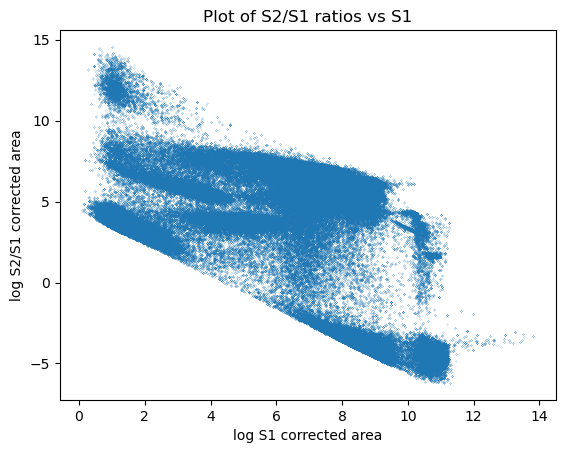

In [27]:
log = np.log(arr['S2_corrected_area'] / arr['S1_corrected_area'])
plt.scatter(x = np.log(arr['S1_corrected_area']), y = log, s = 0.02)
plt.xlabel('log S1 corrected area')
plt.ylabel('log S2/S1 corrected area')
plt.title('Plot of S2/S1 ratios vs S1')

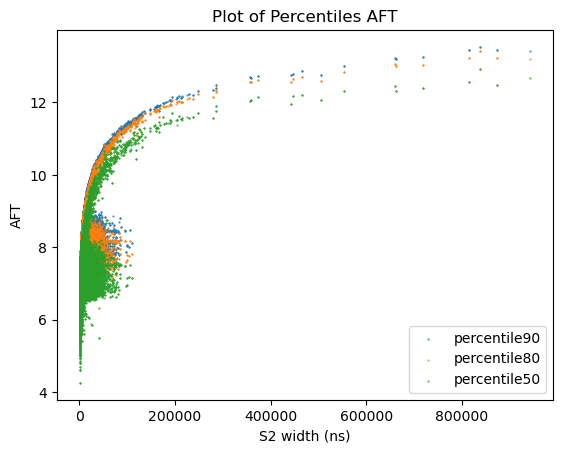

In [28]:
percentile90 = np.log(arr['S2_AFT_95'] - arr['S2_AFT_5'])
percentile80 = np.log(arr['S2_AFT_90'] - arr['S2_AFT_10'])
percentile50 = np.log(arr['S2_AFT_75'] - arr['S2_AFT_25'])
plt.scatter(x = arr['S2_width_ns'], y = percentile90, s = 0.2, label = 'percentile90')
plt.scatter(x = arr['S2_width_ns'], y = percentile80, s = 0.2, label =  'percentile80')
plt.scatter(x = arr['S2_width_ns'], y = percentile50, s = 0.2, label = 'percentile50')
plt.xlabel('S2 width (ns)')
plt.ylabel('AFT')
plt.legend()
plt.title('Plot of Percentiles AFT')
plt.show()

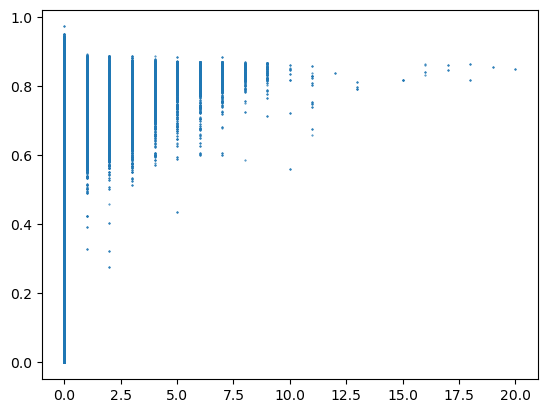

In [29]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

plt.scatter(arr['drift_time'], gaussian(arr['drift_time'], arr['S2_rmsWidth_ns'], arr['S2_fwhm_ns']/2), s = 0.2)

Text(0.5, 1.0, 'Plot of peak amplitude vs rms width')

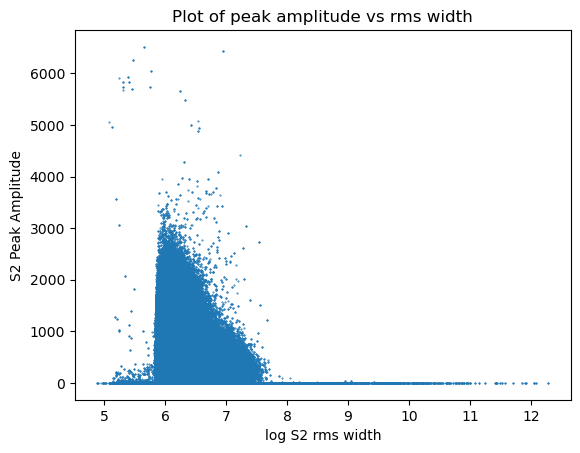

In [30]:
plt.scatter(x = np.log(arr['S2_rmsWidth_ns']), y = arr['S2_peakAmp'], s = 0.2)
plt.ylabel('S2 Peak Amplitude')
plt.xlabel('log S2 rms width')
plt.title('Plot of peak amplitude vs rms width')

Text(0.5, 1.0, 'Plot of top and bottom areas')

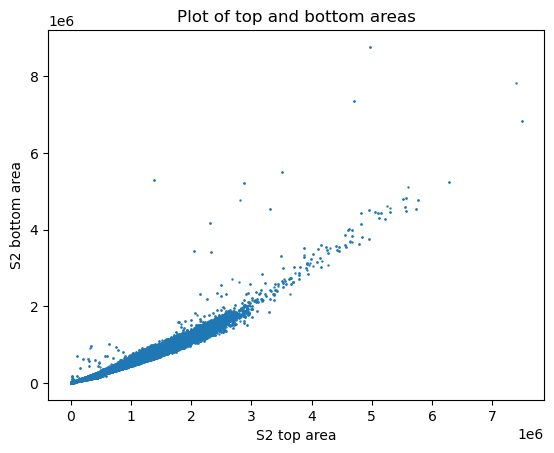

In [31]:
plt.scatter(x = arr['S2_top_area'], y = arr['S2_btm_area'], s = 0.5)
plt.xlabel('S2 top area')
plt.ylabel('S2 bottom area')
plt.title('Plot of top and bottom areas')

In [ ]:
#X,Y = np.meshgrid(arr['S2_area'],arr['S1_area'])
#plt.contour(X, Y)
plt.hist2d(arr['S2_area'],arr['S1_area'])
plt.xlabel('S2 area')
plt.ylabel('S1 area')
#plt.xlim([0, 0.6e7])
#plt.ylim([0, 20000])
plt.title('Plot of S1 and S2')

In [ ]:
plt.errorbar(arr['drift_time'], arr['S2_XY_corrected_area'], yerr = arr['S2_xy_chiSq'], fmt = 'o', ms = 0.2)
plt.xlabel('drift time (ns)')
plt.ylabel('S2 xy corrected area')
plt.title('d') #sampling rate every 10ns 

In [ ]:
fig, ax = plt.subplots()
conditions=(arr['S2_area']<0.6e7) & (arr['S1_area']<20000)
h = ax.hist2d(arr['S2_area'].to_numpy()[conditions], 
              arr['S1_area'].to_numpy()[conditions], 
              bins=200, norm=LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 area')
plt.ylabel('S1 area')
plt.title('Plot of S1 and S2')

In [ ]:
arr.evtID.value_counts().index

In [ ]:
x = arr["evtID"].value_counts().index
y = arr["evtID"].value_counts().values
print(x)
f = plt.figure(1, figsize = (16,6))
ax1 = f.add_subplot(1, 2, 1)
ax1.title.set_text("Type")
_ = ax1.bar(x, y)

z = arr["S2_XY_corrected_area"].value_counts().index
ax2 = f.add_subplot(1, 2, 2)
ax2.title.set_text("Type")
_ = ax2.boxplot(z)

In [ ]:
contamination = 0.01

data = arr.copy()
for col in data.columns:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col].fillna("None", inplace = True)
        le.fit(list(data[col].astype(str).values))
    else: data[col].fillna(-999, inplace = True)

data.head()

In [ ]:
model = IsolationForest(contamination = contamination, n_estimators = 1000)
model.fit(data)

In [ ]:
arr["iforest"] = pd.Series(model.predict(data))
arr["iforest"] = arr["iforest"].map({1 : 0, -1: 1})
print(arr["iforest"].value_counts())

In [ ]:
outliers=arr.loc[arr["iforest"]==0]
outlier_index=list(outliers.index)

NameError: name 'outlier_index' is not defined

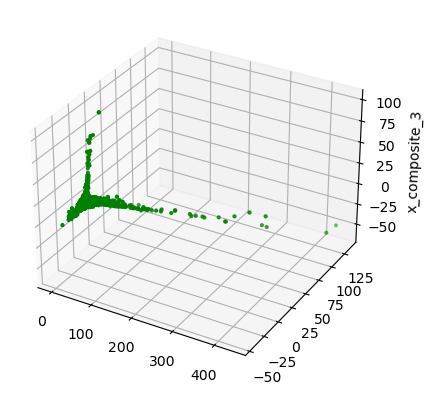

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(arr.dropna())
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [ ]:
inliers = []
outliers = []

In [ ]:
for idx1 in arr.index:
    if arr["iforest"][idx1]==0:
            a=False
    elif arr["iforest"][idx1]==1:
            a=True  
    if a: 
        inliers.append(arr["iforest"][idx1])
    else:
        outliers.append(arr["iforest"][idx1])

print(len(outliers))

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_train)

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    arr["iforest"],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(arr["iforest"][:, 0], arr["iforest"][:, 1], c=arr["iforest"], s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

In [ ]:
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Loading dataset
iris_df = datasets.load_iris()
print(iris_df)

# Declaring Model
model = KMeans(n_clusters=3)

# Fitting Model
model.fit(iris_df.data)

# Predicitng a single input
predicted_label = model.predict([[7.2, 3.5, 0.8, 1.6]])

# Prediction on the entire data
all_predictions = model.predict(iris_df.data)

# Printing Predictions
print(predicted_label)
print(all_predictions)

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :3]  # we only take the first two features.
y = iris.target


fig = plt.figure(figsize=(10,10))
plt = fig.add_subplot(111, projection='3d')
plt.scatter(X[:,0],X[:,1],X[:,2], 
            c=all_predictions, edgecolor='red', s=40, alpha = 0.5)
plt.set_title("First three PCA directions")
plt.set_xlabel("Educational_Degree")
plt.set_ylabel("Gross_Monthly_Salary")
plt.set_zlabel("Claim_Rate")
plt.dist = 10
plt